# Tutorial: Remote Quantum Operations

## Introduction

This tutorial assumes some familiarity with quantum circuits and QISkit. We will walk through a variety of ways one can use particular quantum states (also known as "resource states") as a mediator for quantum operations. The resource state we will be focusing on is the so-called Einstein-Podolsky-Rosen (or EPR) state. We will be using a small library that implements some EPR-mediated quantum operations.

Let's start by installing the `remoteOps` package from this [GitHub repository](http://github.com). Simply clone and install with pip:
```
git clone https://github.com/EntangledNetworks/remoteOps && pip install ./remoteOps
```

Removing the small package from your system is equally easy:
```
pip uninstall remoteOps
```

In [77]:
# Import
import qiskit.circuit as qc
from qiskit.compiler import transpile
import remoteOps
import numpy as np

## Background
Quantum information processing (QIP) tends to rely on operations on multiple qubits in order to be useful. This is entirely analogous to the fact that unary operators in <i>classical</i> information processing themselves are not terribly useful without binary ones as well.

Classically, a binary gate can only be performed between distant bits if one of the operands is transmitted. For example, if Alice possesses a bit "<b><i>a</i></b>" and Bob has a bit "<b><i>b</i></b>", a binary operation that jointly operates on <b><i>a</i></b> and <b><i>b</i></b> cannot happen unless Alice sends a copy of <b><i>a</i></b> to Bob or vice-versa.

In QIP by contrast, a fascinating result is that neither (quantum) operand needs be transmitted, as long as each party in possession of an operand also possesses some shared (entangled) resource state. That state can then be used, along with the transmission of <i>classical</i> information, for a two-qubit operator to be effected between distant qubits even when neither qubit is in fact being transmitted.

In this tutorial, we will default to using the two-qubit EPR state as a resource state:
<center>
$\left|\Phi_{+}\right>=\frac{\left|00\right>+\left|11\right>}{\sqrt{2}}$
</center>

We provide simple instructions to prepare and use this resource state. To start, let's see how these might be used in practice.

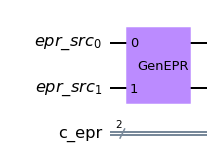

In [3]:
# Define a register to hold the state.
example_qreg = qc.QuantumRegister(2, "epr_src")
# Define an empty quantum circuit
example_circuit = qc.QuantumCircuit(example_qreg)
# Now add an EPR generation instruction
remoteOps.addInstr(example_circuit, 'GenEPR', epr_qreg=example_qreg)

example_circuit.draw(output='mpl')

This EPR generation step might be realised by a [physical process](https://www.nature.com/articles/nphys3150) designed to generate these EPR states directly. Alternatively one may choose to synthesize these logically with a sequence of gates that produces an EPR state.

When the latter approach is desirable (e.g. when performing a simulation with the Aer simulator, say), it is convenient to re-write the GenEPR instruction in terms of more basic gates. We provide an instruction to do so:

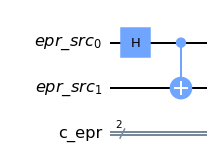

In [18]:
# Decompose complex/custom instructions into more basic gates
remoteOps.decompose(example_circuit)

example_circuit.draw(output='mpl')

## Using EPR states: Remote CX (simple example)
The [controlled-NOT](https://qiskit.org/textbook/ch-gates/multiple-qubits-entangled-states.html#cnot) (a.k.a. CX or CNOT) gate is a common two-qubit gate that is a quantum-coherent analogue of the classical [exclusive-OR](https://en.wikipedia.org/wiki/XOR_gate) (a.k.a. XOR).

In the mini library, we provide custom instructions that utilize EPR states to realize various two-qubit operations, including the CX gate. We'll now start with a simple and arbitrary circuit, and then construct an equivalent one where the CX gate in it is replaced with an EPR-mediated one.

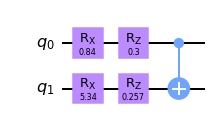

In [5]:
# Generate random gate parameters.
a,b,c,d = np.random.rand(4)*2*np.pi

# Create a circuit
ex_cx_1 = qc.QuantumCircuit(2)
ex_cx_1.rx(a,0)
ex_cx_1.rx(b,1)
ex_cx_1.rz(c,0)
ex_cx_1.rz(d,1)
ex_cx_1.cnot(0,1) # We will replace this with an EPR operation.

# Print
ex_cx_1.draw(output='mpl')

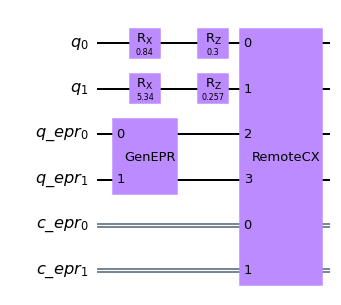

In [19]:
# Now let's compose the same circuit with an EPR-mediated CX
qreg_cx_2 = qc.QuantumRegister(2, 'q')
ex_cx_2 = qc.QuantumCircuit(qreg_cx_2)
ex_cx_2.rx(a,0)
ex_cx_2.rx(b,1)
ex_cx_2.rz(c,0)
ex_cx_2.rz(d,1)
# This invocation inserts a custom EPR-mediated CX instruction
remoteOps.addInstr(ex_cx_2, 'RemoteCX', qreg_cx_2[0], qreg_cx_2[1],[])

# Print
ex_cx_2.draw(output='mpl',cregbundle=False)

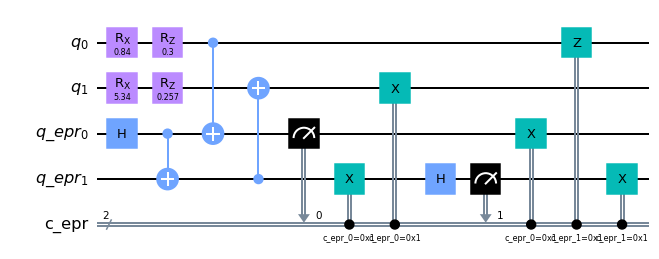

In [20]:
# As with the GenEPR instruction, this custom RemoteCX
# instruction can also be decomposed into more elementary steps.
remoteOps.decompose(ex_cx_2)
ex_cx_2.draw(output='mpl')

<font color=red>Note that in its decomposed form, operands q0 and q1 never "talk to" each other directly. Instead, they interact via the EPR state stored in register "q_epr", and through the <i>classical</i> register "c_epr".</font>

The ability to perform multi-qubit operations remotely in this manner can become important if, for example, qubit q0 is physically located faraway from q1, and are connected only in the sense that they share the EPR state stored in register q_epr.

## Using EPR states: A slightly more sophisticated case
Here we'll show a <b><i>slightly</i></b> more sophisticated example than an arbitrary circuit with a CX. We'll define two registers ('reg_1' and 'reg_2'). We'll do bitwise addition of qubits within 'reg_1', using 'reg_2' as the output register.

In the first instance, we'll simply write down a simple circuit that leaves the most-significant-bit (MSB) of the result in 'reg_2' qubit 0, and the LSB in 'reg_2' qubit 1. That is, we want the following map between reg_1 and reg_2:

reg_1 | reg_2
--|--
00 | 00
01 | 01
10 | 01
11 | 10

As a case study, we will suppose that the two registers ('reg_1' and 'reg_2') can only undergo two-qubit operations via an EPR state. That is, they may be physically distant.

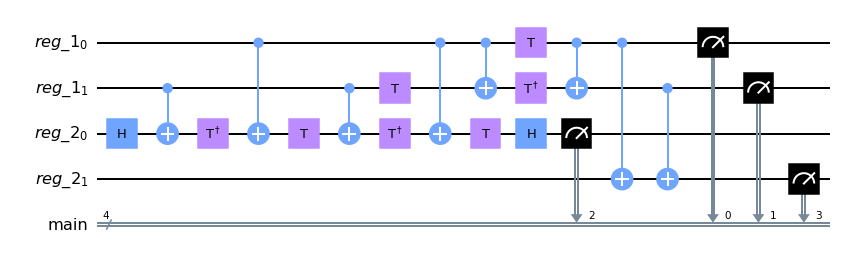

In [62]:
# Define registers
qreg_1 = qc.QuantumRegister(2, "reg_1")
qreg_2 = qc.QuantumRegister(2, "reg_2")
creg_main = qc.ClassicalRegister(4, "main")
ex_adder = qc.QuantumCircuit(qreg_1, qreg_2, creg_main)

# Do bitwise addition.
ex_adder.ccx(qreg_1[0], qreg_1[1], qreg_2[0])
ex_adder.cx(qreg_1[0], qreg_2[1])
ex_adder.cx(qreg_1[1], qreg_2[1])

# Substitute Toffoli with more basic gates:
ex_adder = transpile(ex_adder, basis_gates=['cx','t','tdg','h'])

# Measure results
ex_adder.measure(qreg_1,creg_main[0:2])
ex_adder.measure(qreg_2,creg_main[2:4])

ex_adder.draw(output='mpl')

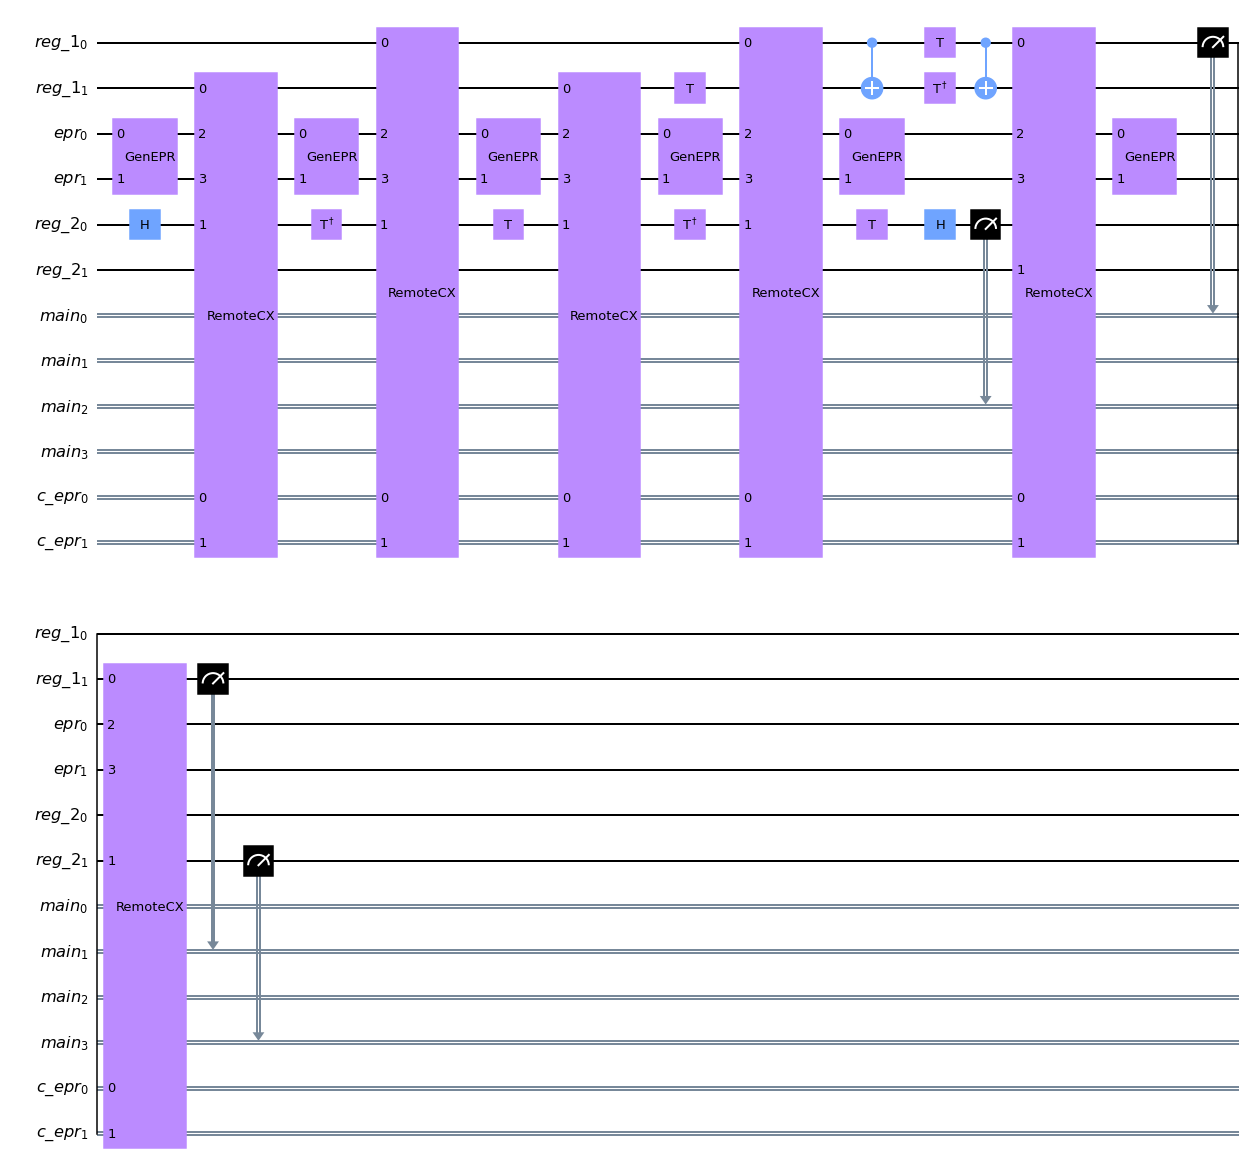

In [65]:
# Suppose any CX operation between Registers 1 and 2 can only happen via EPR-mediation.

# Define an "epr" register for our circuit.
# Note, this is not *strictly* necessary. As seen above, a placeholder
# register is automatically inserted if we hadn't provided one.
qreg_epr = qc.QuantumRegister(2, 'epr')

# Also add a classical register to hold any results.
creg_main = qc.ClassicalRegister(4, 'main')
ex_adder_epr = qc.QuantumCircuit(qreg_1, qreg_epr, qreg_2, creg_main)

# Port over the existing circuit
ex_adder_epr.data = ex_adder.data

# Now call the autosubstitute routine, instructing it to
# replace any operations that cross registers 1 and 2.
remoteOps.autosubstitute(ex_adder_epr, reglist=[qreg_1,qreg_2], epr_qreg=qreg_epr)


ex_adder_epr.draw(output='mpl',cregbundle=False)

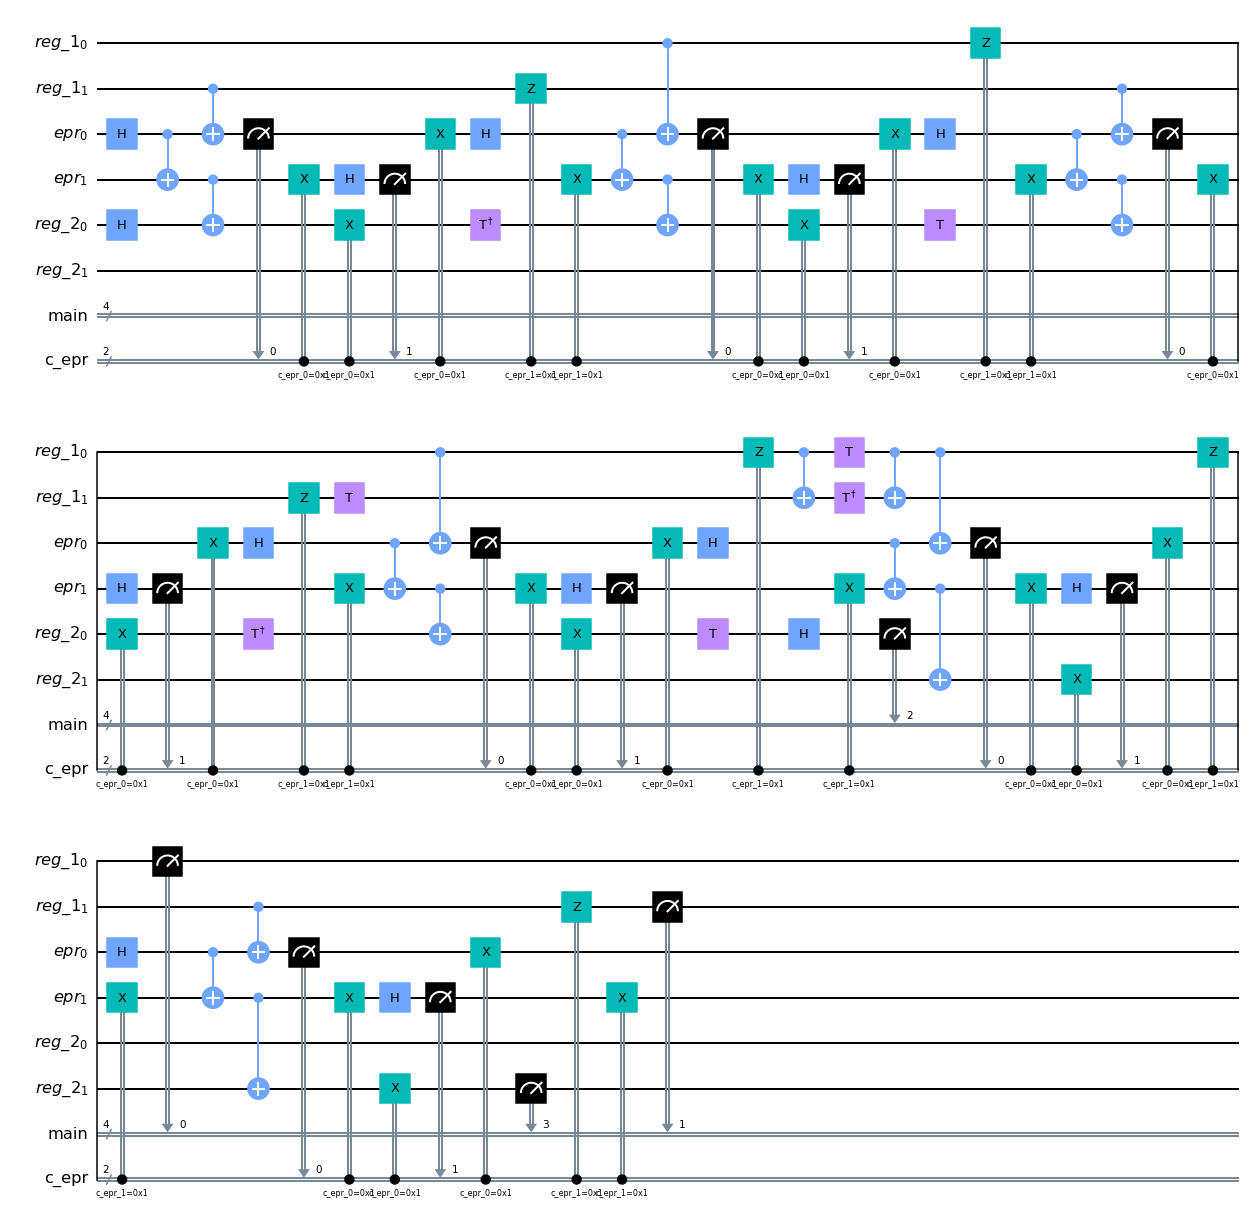

In [66]:
# Finally, we can decompose these if we want (though it won't be pretty to look at!)
remoteOps.decompose(ex_adder_epr)

ex_adder_epr.draw(output='mpl')

<font color=red>Once again, notice that nothing in the EPR-mediated circuit, all qubits in reg_1 only "talks to" the EPR register. The same is true for the reg_2 register. No qubit in reg_1 "talks to" any qubit in reg_2, and vice versa.</font>

Again, a natural way to understand the use-case shown in this example is to imagine a quantum processor holding qubits in reg_1 attempting to do bit-wise addition, but then store the results in reg_2 that is held in a distant quantum computer. Now if the two quantum processors share an EPR state, then that addition can proceed as shown above.

### Better efficiency through re-ordering
Now in all the examples shown so far, we've used the EPR resource state purely for mediating CX operations.

In this sub-section, we'll stick with the adder example, but show that sometimes we can simply front-load the broadcasting or moving of qubits which can sometimes yield more efficient circuits.

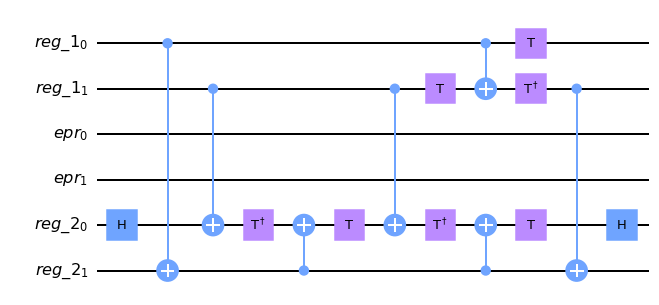

In [15]:
# As before, we'll define an empty circuit first.
ex_adder_tele = qc.QuantumCircuit(qreg_1, qreg_epr, qreg_2)

# The penultimate CX in our original circuit can occur first:
ex_adder_tele.cx(qreg_1[0], qreg_2[1])

# Now, as long as there are no hadamards in either reg_1[0] or reg_2[1],
# we essentially have the first qubit of reg_1 "broadcasted" across registers.
# Now we can do the Toffoli, taking care to minimize inter-register operations.
ex_adder_tele.h(qreg_2[0])
ex_adder_tele.cx(qreg_1[1], qreg_2[0])
ex_adder_tele.tdg(qreg_2[0])
ex_adder_tele.cx(qreg_2[1], qreg_2[0])
ex_adder_tele.t(qreg_2[0])
ex_adder_tele.cx(qreg_1[1], qreg_2[0])
ex_adder_tele.t(qreg_1[1])
ex_adder_tele.tdg(qreg_2[0])
ex_adder_tele.cx(qreg_2[1], qreg_2[0])
ex_adder_tele.cx(qreg_1[0], qreg_1[1])
ex_adder_tele.t(qreg_1[0])
ex_adder_tele.tdg(qreg_1[1])
ex_adder_tele.t(qreg_2[0])
ex_adder_tele.h(qreg_2[0])

# LSB xor.
ex_adder_tele.cx(qreg_1[1], qreg_2[1])

ex_adder_tele = transpile(ex_adder_tele, basis_gates=['cx','t','tdg','h'])

ex_adder_tele.draw(output='mpl')

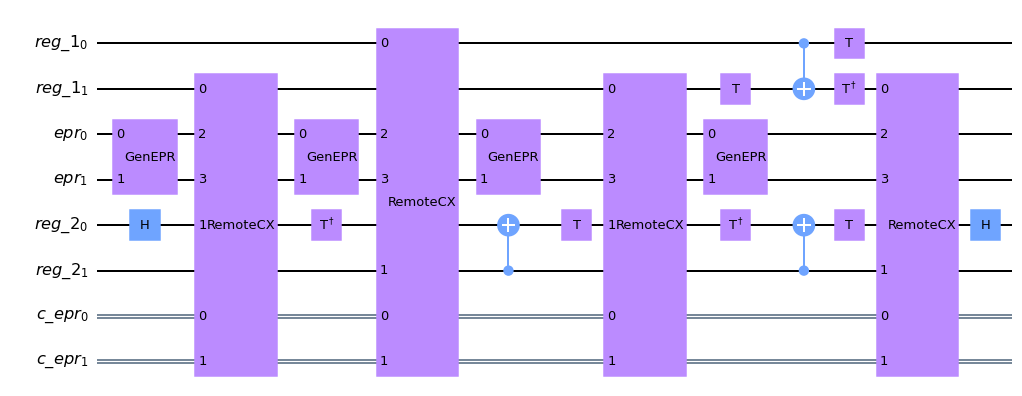

In [16]:
# And as before, autosubstitute with EPR-mediated operations....
remoteOps.autosubstitute(ex_adder_tele, reglist=[qreg_1,qreg_2], epr_qreg=qreg_epr)

ex_adder_tele.draw(output='mpl',cregbundle=False)

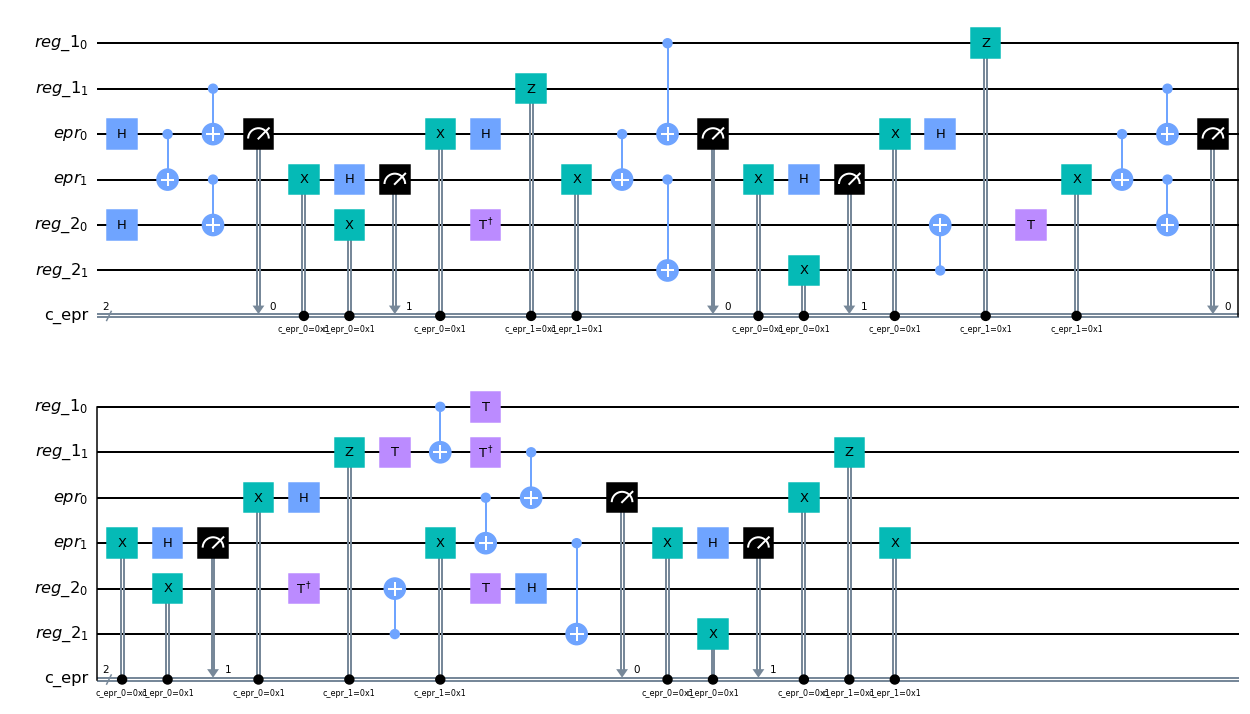

In [17]:
# ... and decompose into fundamental gates.
remoteOps.decompose(ex_adder_tele)

ex_adder_tele.draw(output="mpl")

<font color=red>Note that with a simple re-order of gates, we can broadcast or change the register residency of a qubit, and sometimes end up having to do less work. This can be especially important, for example, when registers 1 and 2 are in fact distant and EPR-mediated operations expensive or time-consuming</font>

So far we have focused primarily on the use of EPR-mediated CX gates. The small library you just installed also contains pre-built substitutions for other common two-qubit operations like CRZ, RZZ, and even straight-up teleportation! Feel free to explore...